# Whole-brain Drosophila computational model reveals sensorimotor processing



In [1]:
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from pathlib import Path

import braintools
import brainstate
import brainunit as u
from drosophila_whole_brain import run_one_exp, ndarray_to_dataframe, flywire_ids, Network

In [2]:
data_path = './'

In [3]:
n_trial = 5
duration = 100. * u.ms

all_neuron_ids = flywire_ids(
    os.path.join(data_path, './2023_03_23_completeness_630_final.csv')
)
flywire_id_to_index = {f: i for i, f in enumerate(all_neuron_ids)}

## Example Trial

In [4]:
# define inputs
# list of the labellar sugar-sensing gustatory receptor neurons on right hemisphere
neu_sugar = [
    720575940624963786, 720575940630233916, 720575940637568838, 720575940638202345, 720575940617000768,
    720575940630797113, 720575940632889389, 720575940621754367, 720575940621502051, 720575940640649691,
    720575940639332736, 720575940616885538, 720575940639198653, 720575940620900446, 720575940617937543,
    720575940632425919, 720575940633143833, 720575940612670570, 720575940628853239, 720575940629176663,
    720575940611875570,
]

In [5]:
def example_to_run(duration=1000 * u.ms):
    with brainstate.environ.context(dt=0.1 * u.ms):
        net = Network(
            path_neu=os.path.join(data_path, './2023_03_23_completeness_630_final.csv'),
            path_syn=os.path.join(data_path, './2023_03_23_connectivity_630_final.parquet'),
            neuron_to_excite=[
                # sugar neuron
                {
                    'ids': neu_sugar,
                    'rate': 150 * u.Hz
                },
                # other neuron groups
            ],
        )
        brainstate.nn.init_all_states(net)

        indices = np.arange(int(duration / brainstate.environ.get_dt()))
        times = indices * brainstate.environ.get_dt()
        spks = brainstate.transform.for_loop(lambda i: net.step_run(i, ret_val='spike'), indices, pbar=1000)

    fig, gs = braintools.visualize.get_figure(1, 1, 5, 5)
    ax = fig.add_subplot(gs[0, 0])
    i_times, i_indices = np.where(spks)
    plt.scatter(times[i_times], i_indices, s=1)
    plt.xlabel('Time [ms]')
    plt.ylabel('Neuron index')
    plt.ylim(0, net.n_neuron)
    plt.xlim(0 * u.ms, duration)
    plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

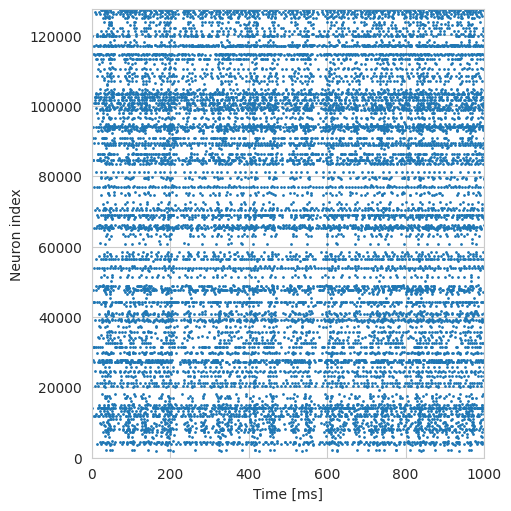

In [6]:
example_to_run()

## Figure 1

In [7]:
fig1_path_res = Path('./figure_1')
os.makedirs(fig1_path_res, exist_ok=True)

### Figure 1 D: Whole Brain Activity when Activating Sugar GRN

In [8]:
# frequencies
freqs = np.arange(10, 201, 20)

In [9]:
def whole_brain_activation():
    @brainstate.transform.vmap
    def run_with_freq(freq_):
        return run_one_exp(
            neurons_to_excite=[{'ids': neu_sugar, 'rate': freq_ * u.Hz}],
            duration=duration, pbar=10,
        )

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def run_simulations():
        return run_with_freq(freqs)

    if not os.path.exists(fig1_path_res / 'firing_rate.csv'):
        rates = run_simulations()

        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'{freq} Hz' for freq in freqs],
                all_neuron_ids
            ],
            column_axis=0
        )
        df.to_csv(fig1_path_res / 'firing_rate.csv')

        df_rate = df.loc['190 Hz'].mean(axis=1)
        df_rate_std = df.loc['190 Hz'].std(axis=1)

        # save 200 neurons for next simulation
        id_top200 = df_rate.sort_values(ascending=False).index[:200]

        print(df_rate.sort_values(ascending=False))

        with open(fig1_path_res / 'fig_1d_id_top200.pickle', 'wb') as f:
            pickle.dump(id_top200, f)

In [10]:
whole_brain_activation()

  0%|          | 0/1000 [00:00<?, ?it/s]

dim_2
720575940638202345    250.0
720575940639332736    222.0
720575940620900446    222.0
720575940639198653    218.0
720575940630797113    218.0
                      ...  
720575940620594014      0.0
720575940620594000      0.0
720575940620593840      0.0
720575940620593835      0.0
720575940660868737      0.0
Length: 127400, dtype: float32


### Figure 1 E:  Which neurons activate MN9?

In [22]:
# define inputs
# flywire ID for MN9
id_mn9 = 720575940660219265

index_id_mn9 = flywire_id_to_index[id_mn9]

# identify the top 200 neurons that respond due to 200 Hz sugar firing (Figure 1D)
with open(fig1_path_res / 'fig_1d_id_top200.pickle', 'rb') as f:
    id_top200 = pickle.load(f)

In [23]:
# neuron indices
indices = np.asarray([flywire_id_to_index[id_] for id_ in id_top200])
indices = np.expand_dims(indices, axis=1)

In [24]:
def which_neuron_activate_MN9(freqs):
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_freq(freq_, indices_):
        assert indices_.ndim == 1 and indices_.size == 1
        rate = run_one_exp(
            neurons_to_excite=[{'indices': indices_, 'rate': freq_ * u.Hz}],
            duration=duration,
            pbar=10
        )
        return rate[index_id_mn9]

    def run_with_indices(indices_):
        return run_with_freq(freqs, indices_)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        # due to the limited memory of the device, we choose using "brainstate.transform.map" instead of "brainstate.transform.vmap"

        # return bst.transform.vmap(run_with_indices)(bst.random.split_key(len(indices)), indices)
        return brainstate.transform.map(run_with_indices, indices, batch_size=20)

    path = fig1_path_res / f'which_neuron_activate_NM9_firing_rate.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                id_top200,
                [f'{freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [25]:
which_neuron_activate_MN9(
    np.asarray([25, 50, 75, 100, 125, 150, 175, 200])
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

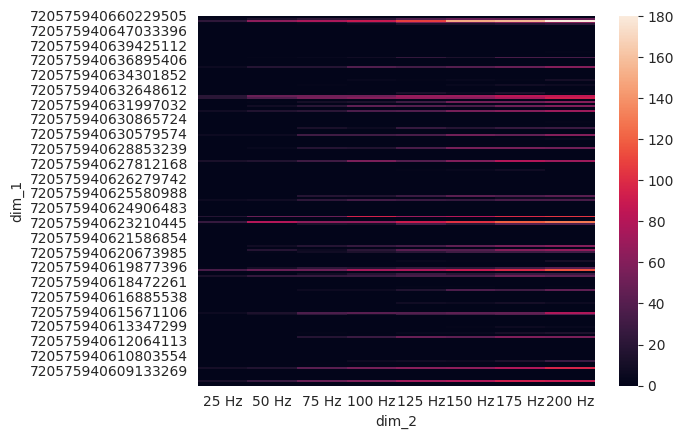

In [26]:
df = pd.read_csv(fig1_path_res / f'which_neuron_activate_NM9_firing_rate.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df.sort_index(ascending=False, inplace=True)
pivot_df = pivot_df.fillna(0)
pivot_df = pivot_df.reindex([f'{f} Hz' for f in [25, 50, 75, 100, 125, 150, 175, 200]], axis=1)

sns.heatmap(pivot_df)
plt.show()

### Figure 1F: Silencing

In [30]:
# neuron indices
silencing_indices = np.asarray([flywire_id_to_index[id_] for id_ in id_top200])
silencing_indices = np.expand_dims(silencing_indices, axis=1)

In [31]:
def slice_neuron_and_activate_MN9(freqs):
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_freq(freq_, indices_):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_sugar, 'rate': freq_ * u.Hz}],
            neuron_to_inhibit=[{'indices': indices_}],
            duration=duration,
            pbar=10
        )
        return rate[index_id_mn9]

    def run_with_indices(indices_):
        return run_with_freq(freqs, indices_)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        # Due to the limited memory of the device, we choose using "brainstate.transform.map" instead of "brainstate.transform.vmap"
        # Decrease "batch_size" when out of memory

        # return bst.transform.vmap(run_with_indices)(bst.random.split_key(len(silencing_indices)), silencing_indices)
        return brainstate.transform.map(run_with_indices, silencing_indices, batch_size=20)

    path = fig1_path_res / f'sugarR-silencing_which_neuron_firing_rate.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                id_top200,
                [f'{freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [32]:
slice_neuron_and_activate_MN9(
    np.asarray([50, 60, 70, 80, 90, 100, 110, 120])
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

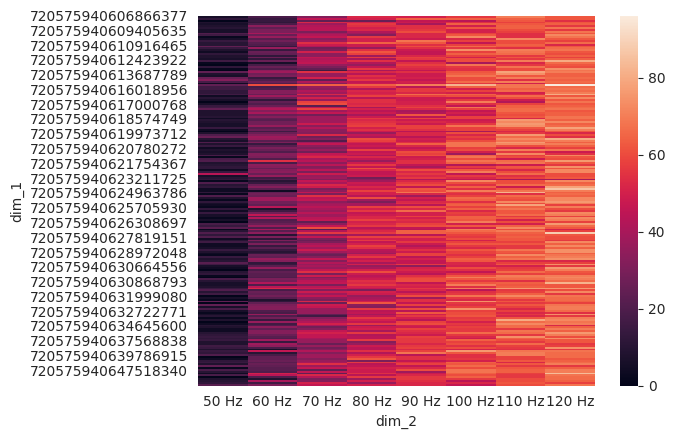

In [33]:
df = pd.read_csv(fig1_path_res / f'sugarR-silencing_which_neuron_firing_rate.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)
pivot_df = pivot_df.reindex([f'{f} Hz' for f in [50, 60, 70, 80, 90, 100, 110, 120]], axis=1)

sns.heatmap(pivot_df)
plt.show()

## Figure 2: Which Cell Type Activates MN9?

In [34]:
# output path
fig2_path_res = Path('./figure_2')
os.makedirs(fig2_path_res, exist_ok=True)

In [35]:
# define input
ids_two_mn9 = [720575940660219265, 720575940645521262]  # left and right

index_id_mn9 = np.asarray(
    [flywire_id_to_index[ids_two_mn9[0]],
     flywire_id_to_index[ids_two_mn9[1]]]
)

with open('./sez_neurons.pickle', 'rb') as f:
    types_and_ids = pickle.load(f)

In [36]:
def which_cell_type_activates_MN9(cell_ids, type_name, freqs):
    @brainstate.transform.vmap
    def run_with_freq(freq_):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': cell_ids, 'rate': freq_ * u.Hz}],
            duration=duration,
            pbar=10
        )
        return rate[index_id_mn9]

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        return run_with_freq(freqs)

    path = fig2_path_res / f'cell_type={type_name}.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'{freq} Hz' for freq in freqs],
                ids_two_mn9
            ],
            column_axis=0
        )
        df.to_csv(path)

In [37]:
for cell_type_name, neurons in types_and_ids.items():
    print('Activating MN9 with cell type', cell_type_name)
    which_cell_type_activates_MN9(
        neurons,
        cell_type_name,
        np.asarray([50, 100, 150, 200])
    )

Activating MN9 with cell type aDT6


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type amulet


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type aSG1


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type aSG7


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type aster


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type Asteroid


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type bamboo


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type basket


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type bluebell


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type bobber


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type box


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type bract


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type bridle


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type brontosaraus


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type broom


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type buddy


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type clavicle


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type coy


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type crab


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type cradle


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type damsel


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type diatom


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type doublescoop


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type earmuff


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type eiffel


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type Fdg


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type fluff


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type FMIn


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type foxglove


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type fudog


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type G2N_1


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type gallinule


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type gazebo


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type genie


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type gnome


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type good_dog


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type gumdrop


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type handle


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type handup


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type haystack


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type horntail


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type horseshoe


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type horn


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type hound


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type hyacinth


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type justice


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type kelp


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type kitty


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type knees


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type kokopelli


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type landslide


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type lion


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type mandala


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type marge


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type meteor


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type mime


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type mist


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type moor


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type mothership


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type mute


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type nagini


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type nori


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type oink


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type OinkT


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type oval


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type peacock


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type peahen


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type peafowl


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type phantom


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type planter


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type pleco


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type pringle


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type pSG1


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type puddle


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type rattle


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type rocket


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type rose


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type roundup


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type ruby


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type Salivary_MN13


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type seagull


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type shark


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type sink_sync


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type snake


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type spray


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type spirit


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type sullivan


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type sundrop


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type tentacular


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type TH_VUM


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type tinctoria


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type tophat


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type TPN4


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type trident


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type trogon


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type trumpet


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type tulip


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type tundra


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type turner


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type twirl


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type usnea


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type vice


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type wafflecone


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type weaver


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type web


  0%|          | 0/1000 [00:00<?, ?it/s]

Activating MN9 with cell type whisker


  0%|          | 0/1000 [00:00<?, ?it/s]

In [38]:
# dfs = [
#     pd.read_csv(fig2_path_res / f'cell_type={cell_type_name}.csv').mean(axis=1)
#     for cell_type_name in types_and_ids.keys()
# ]
#
# # process results
# for freq in freqs:
#     plt.figure(figsize=(12, 6))
#     x_labels = list(types_and_ids.keys())
#     y_values = [df.loc[ids_two_mn9].mean() for df in dfs]
#
#     plt.bar(x_labels, y_values, color='skyblue')
#     plt.xlabel('Cell Type')
#     plt.ylabel('Firing of MN9')
#     plt.title(f'Relationship Between Cell Type and MN9 Firing (Frequency = {freq} Hz)')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.show()

TypeError: can only concatenate str (not "int") to str

## Figure 3

In [39]:
fig3_path_res = Path('./figure_3')
os.makedirs(fig3_path_res, exist_ok=True)

### Figure 3 A: Combination of Bitter and Sugar GRN

In [40]:
# define inputs
# lists of all the labelled sugar-sensing gustatory receptor neurons on right hemisphere
neu_bitter = [
    720575940621778381, 720575940602353632, 720575940617094208, 720575940619197093, 720575940626287336,
    720575940618600651, 720575940627692048, 720575940630195909, 720575940646212996, 720575940610483162,
    720575940645743412, 720575940627578156, 720575940622298631, 720575940621008895, 720575940629146711,
    720575940610259370, 720575940610481370, 720575940619028208, 720575940614281266, 720575940613061118,
    720575940604027168
]

neu_ir94e = [
    720575940614211295, 720575940638218173, 720575940628832256, 720575940626016017, 720575940621375231,
    720575940612920386, 720575940614273292, 720575940628198503, 720575940626241636, 720575940619387814,
    720575940624604560, 720575940615274425, 720575940610683315, 720575940627265265, 720575940624079544,
    720575940629211607, 720575940615089369, 720575940631082124
]

id_mn9 = 720575940660219265  # left
index_mn9 = flywire_id_to_index[id_mn9]

In [41]:
def sugar_bitter_activate_MN9(freqs):
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_sugar_freq(sugar_freq, bitter_freq):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_sugar, 'rate': sugar_freq * u.Hz},
                               {'ids': neu_bitter, 'rate': bitter_freq * u.Hz}],
            duration=duration,
            pbar=10,
        )
        return rate[index_mn9]

    @brainstate.transform.vmap
    def run_with_bitter_freq(bitter_freq):
        return run_with_sugar_freq(freqs, bitter_freq)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        return run_with_bitter_freq(freqs)

    path = fig3_path_res / f'sugar_bitter_activate_MN9.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'bitter {freq} Hz' for freq in freqs],
                [f'sugar {freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [42]:
sugar_bitter_activate_MN9(
    np.asarray([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
)

  0%|          | 0/1000 [00:00<?, ?it/s]

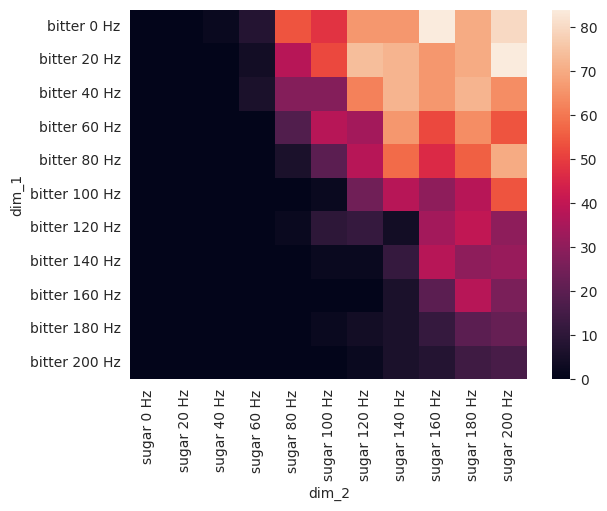

In [43]:
df = pd.read_csv(fig3_path_res / f'sugar_bitter_activate_MN9.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)
pivot_df = pivot_df.reindex([f'sugar {f} Hz' for f in [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]], axis=1)
pivot_df = pivot_df.reindex([f'bitter {f} Hz' for f in [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]], axis=0)

sns.heatmap(pivot_df)
plt.show()

### Figure 3 B: Combination of Sugar and IR94e GRN

In [44]:
def sugar_ir94e_activates_MN9(freqs):
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_sugar_freq(sugar_freq, ir94e_freq):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_sugar, 'rate': sugar_freq * u.Hz},
                               {'ids': neu_ir94e, 'rate': ir94e_freq * u.Hz}],
            duration=duration,
            pbar=10,
        )
        return rate[index_mn9]

    @brainstate.transform.vmap
    def run_with_ir94e_freq(ir94e_freq):
        return run_with_sugar_freq(freqs, ir94e_freq)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        return run_with_ir94e_freq(freqs)

    path = fig3_path_res / f'sugar_ir94e_activates_MN9.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'ir94e {freq} Hz' for freq in freqs],
                [f'sugar {freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [45]:
sugar_ir94e_activates_MN9(
    np.asarray([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
)

  0%|          | 0/1000 [00:00<?, ?it/s]

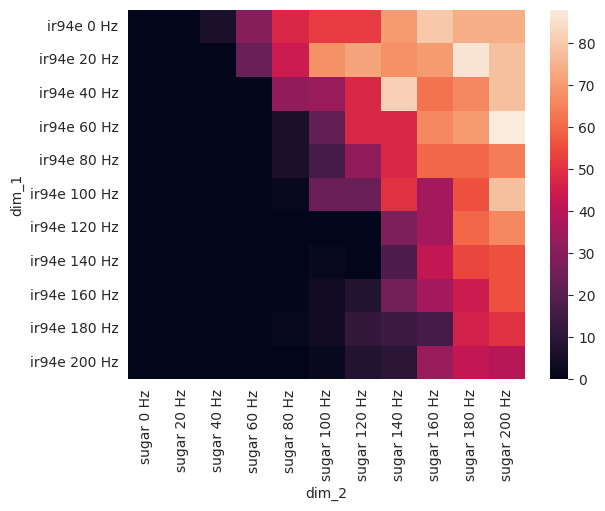

In [46]:
df = pd.read_csv(fig3_path_res / f'sugar_ir94e_activates_MN9.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)
pivot_df = pivot_df.reindex([f'sugar {f} Hz' for f in [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]], axis=1)
pivot_df = pivot_df.reindex([f'ir94e {f} Hz' for f in [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]], axis=0)

sns.heatmap(pivot_df)
plt.show()

## Figure 4

In [47]:
fig4_path_res = Path('./figure_4')
os.makedirs(fig4_path_res, exist_ok=True)

### Figure 4a: Whole Brain Activity when Activating Water GRN

In [48]:
# define inputs
# list of the labelled water-sensing gustatory receptor neurons on right hemisphere
neu_water = [
    720575940612950568, 720575940631898285, 720575940606002609, 720575940612579053, 720575940622902535,
    720575940616177458, 720575940660292225, 720575940622486922, 720575940613786774, 720575940629852866,
    720575940625861168, 720575940613996959, 720575940617857694, 720575940644965399, 720575940625203504,
    720575940630553415, 720575940635172191, 720575940634796536
]

In [49]:
def water_GRN_whole_brain_activation(freqs):
    @brainstate.transform.vmap
    def run_with_freq(freq_):
        return run_one_exp(
            neurons_to_excite=[
                {
                    'ids': neu_water,
                    'rate': freq_ * u.Hz
                }
            ],
            duration=duration,
            pbar=10,
        )

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def run_simulations():
        return run_with_freq(freqs)

    path = fig4_path_res / 'water_GRN_whole_brain_firing_rate.csv'
    if not os.path.exists(path):
        rates = run_simulations()

        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'{freq} Hz' for freq in freqs],
                all_neuron_ids
            ],
            column_axis=0
        )
        df.to_csv(path)

        df_rate = df.loc['260 Hz'].mean(axis=1)
        df_rate_std = df.loc['260 Hz'].std(axis=1)

        # save 200 neurons for next simulation
        id_top200 = df_rate.sort_values(ascending=False).index[:200]

        print(df_rate.sort_values(ascending=False))

        with open(fig4_path_res / 'id_top200_water.pickle', 'wb') as f:
            pickle.dump(id_top200, f)

In [50]:
water_GRN_whole_brain_activation(
    np.asarray([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260])
)

  0%|          | 0/1000 [00:00<?, ?it/s]

dim_2
720575940606002609    288.0
720575940612950568    284.0
720575940631898285    282.0
720575940613996959    276.0
720575940622486922    270.0
                      ...  
720575940620591494      0.0
720575940620591454      0.0
720575940620591425      0.0
720575940620591380      0.0
720575940660868737      0.0
Length: 127400, dtype: float32


### Figure 4b: Which Water GRN activates MN9?

In [51]:
# define inputs
# flywire ID for MN9
id_mn9 = 720575940660219265

index_id_mn9 = flywire_id_to_index[id_mn9]

# identify the top 200 neurons that respond due to 200 Hz water firing (Figure 1D)
with open(fig4_path_res / 'id_top200_water.pickle', 'rb') as f:
    id_top200_water = pickle.load(f)

# neuron indices
water_top200_indices = np.asarray([flywire_id_to_index[id_] for id_ in id_top200_water])
water_top200_indices = np.expand_dims(water_top200_indices, axis=1)

In [55]:
def which_water_neuron_activate_MN9(freqs):
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_freq(freq_, indices_):
        assert indices_.ndim == 1 and indices_.size == 1
        rate = run_one_exp(
            neurons_to_excite=[{'indices': indices_, 'rate': freq_ * u.Hz}],
            duration=duration,
            pbar=10
        )
        return rate[index_id_mn9]

    def run_with_indices(indices_):
        return run_with_freq(freqs, indices_)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        # due to the limited memory of the device, we choose using "brainstate.transform.map" instead of "brainstate.transform.vmap"

        # return bst.transform.vmap(run_with_indices)(bst.random.split_key(len(water_top200_indices)), water_top200_indices)
        return brainstate.transform.map(run_with_indices,
                                        water_top200_indices,
                                        batch_size=10)

    path = fig4_path_res / f'which_water_neuron_activate_NM9_firing_rate.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                id_top200_water,
                [f'{freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
which_water_neuron_activate_MN9(
    np.asarray([25, 50, 75, 100, 125, 150, 175, 200])
)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
df = pd.read_csv(fig4_path_res / f'which_water_neuron_activate_NM9_firing_rate.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)

sns.heatmap(pivot_df)
plt.title('Which Water GRN activates NM9?')
plt.show()

### Figure 4c: Silencing Most Active Neurons while Activating Water GRN

In [ ]:
# neuron indices
water_silencing_indices = np.asarray([flywire_id_to_index[id_] for id_ in id_top200])
water_silencing_indices = np.expand_dims(water_silencing_indices, axis=1)

In [ ]:
def slice_water_neuron_and_activate_MN9(freqs):
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_freq(freq_, indices_):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_water, 'rate': freq_ * u.Hz}],
            neuron_to_inhibit=[{'indices': indices_}],
            duration=duration,
            pbar=10
        )
        return rate[index_id_mn9]

    def run_with_indices(indices_):
        return run_with_freq(freqs, indices_)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        # due to the limited memory of the device, we choose using "brainstate.transform.map" instead of "brainstate.transform.vmap"

        # return bst.transform.vmap(run_with_indices)(bst.random.split_key(len(water_silencing_indices)), water_silencing_indices)
        return brainstate.transform.map(run_with_indices, water_silencing_indices, batch_size=20)

    path = fig4_path_res / f'water_neuron_silencing_firing_rate.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                id_top200,
                [f'{freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
slice_water_neuron_and_activate_MN9(
    np.asarray([160, 170, 180, 190, 200, 210, 220])
)

In [ ]:
df = pd.read_csv(fig4_path_res / f'water_neuron_silencing_firing_rate.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)

sns.heatmap(pivot_df)
plt.show()

### Figure 4e: Combination of sugar and water GRN activity

In [ ]:
sugar_freqs = np.asarray([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
water_freqs = np.asarray([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260])

In [ ]:
def sugar_water_activates_MN9():
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_sugar_freq(sugar_freq, water_freq):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_sugar, 'rate': sugar_freq * u.Hz},
                               {'ids': neu_water, 'rate': water_freq * u.Hz}],
            duration=duration,
            pbar=10,
        )
        return rate[index_mn9]

    @brainstate.transform.vmap
    def run_with_water_freq(water_freq):
        return run_with_sugar_freq(sugar_freqs, water_freq)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        return run_with_water_freq(water_freqs)

    path = fig4_path_res / f'sugar_water_activates_MN9.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'water {freq} Hz' for freq in water_freqs],
                [f'sugar {freq} Hz' for freq in sugar_freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
sugar_water_activates_MN9()

In [ ]:
df = pd.read_csv(fig4_path_res / f'sugar_water_activates_MN9.csv')
sns.heatmap(df)

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)

sns.heatmap(pivot_df)
plt.show()

## Figure 5

In [54]:
fig5_path_res = Path('./figure_5/data')
os.makedirs(fig5_path_res, exist_ok=True)

### Figure 5b: Whole Brain Activity when Activating JON

In [ ]:
# define inputs
# list of the  JONs
neu_JON_CE = [
    720575940619341105, 720575940630122015, 720575940611061526, 720575940615848788, 720575940628444667,
    720575940627941431, 720575940632449619, 720575940650244342,
    720575940631866508, 720575940638681845, 720575940628978450, 720575940609522461, 720575940621442224,
    720575940602506208, 720575940629022149, 720575940627109991,
    720575940630020111, 720575940615986459, 720575940618684481, 720575940620382889, 720575940630080071,
    720575940626565455, 720575940630319671, 720575940602720940,
    720575940630564179, 720575940637632419, 720575940615809349, 720575940626042149, 720575940637054835,
    720575940602132509, 720575940614188149, 720575940616951124,
    720575940628101126, 720575940629055721, 720575940616589878, 720575940622449388, 720575940614427195,
    720575940625797617, 720575940638664437, 720575940618467195,
    720575940621729757, 720575940613971485, 720575940627585688, 720575940629650997, 720575940630059847,
    720575940608742409, 720575940614351477, 720575940633153375,
    720575940622937528, 720575940604753437, 720575940611783464, 720575940618599872, 720575940609541917,
    720575940637410869, 720575940630070343, 720575940621397417,
    720575940614035485, 720575940610018266, 720575940626307902, 720575940634634606, 720575940614060829,
    720575940624799290, 720575940641921421, 720575940623298559,
    720575940625559358, 720575940629138959, 720575940621625597, 720575940625962568, 720575940632767383,
    720575940624915230]

neu_JON_F = [
    720575940606239243, 720575940626956777, 720575940604973746, 720575940622222856, 720575940642517284,
    720575940629719404, 720575940616613022, 720575940604299454,
    720575940615473186, 720575940622217992, 720575940606800341, 720575940629267498, 720575940637366335,
    720575940624224408, 720575940609543197, 720575940633364179,
    720575940629502009, 720575940606431189, 720575940625733960, 720575940638529525, 720575940617524053,
    720575940628935564, 720575940624308355, 720575940631170346,
    720575940627704375, 720575940625885512, 720575940614929245, 720575940647493241, 720575940618888368,
    720575940625087546, 720575940606657493, 720575940617273560,
    720575940640591861, 720575940639410035, 720575940621532413, 720575940627523584, 720575940621521917,
    720575940621097398, 720575940625915338, 720575940606222428,
    720575940627868471, 720575940622179497, 720575940608297774, 720575940614026269, 720575940613012959,
    720575940628100614, 720575940606611401, 720575940628649465,
    720575940610008217, 720575940623791152, 720575940625571240, 720575940634923621, 720575940609530653,
    720575940635968745, 720575940625703434, 720575940613105311,
    720575940629386819, 720575940623077389, 720575940625763015, 720575940628359017
]

neu_JON_D_m = [
    720575940630834171, 720575940622892988, 720575940621289537, 720575940641395163, 720575940616064546,
    720575940628978409, 720575940652566177, 720575940627493096,
    720575940619085397, 720575940635545310, 720575940645728803, 720575940629141775, 720575940626557995,
    720575940631098338, 720575940639904475, 720575940635067034]

neu_JON_all = neu_JON_CE + neu_JON_F + neu_JON_D_m

# frequencies
freqs = np.asarray([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220])

In [ ]:
def JON_GRN_whole_brain_activation():
    @brainstate.transform.vmap
    def run_with_freq(freq_):
        return run_one_exp(
            neurons_to_excite=[
                {
                    'ids': neu_JON_all,
                    'rate': freq_ * u.Hz
                }
            ],
            duration=duration,
            pbar=10,
        )

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def run_simulations():
        return run_with_freq(freqs)

    path = fig5_path_res / 'JON_GRN_whole_brain_firing_rate.csv'
    if not os.path.exists(path):
        rates = run_simulations()

        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'{freq} Hz' for freq in freqs],
                all_neuron_ids
            ],
            column_axis=0
        )
        df.to_csv(path)

        df_rate = df.loc['220 Hz'].mean(axis=1)
        df_rate_std = df.loc['220 Hz'].std(axis=1)

        # save 200 neurons for next simulation
        id_top300 = df_rate.sort_values(ascending=False).index[:300]

        print(df_rate.sort_values(ascending=False))

        with open(fig5_path_res / 'id_top300_water.pickle', 'wb') as f:
            pickle.dump(id_top300, f)

In [ ]:
JON_GRN_whole_brain_activation()

### Figure 5c: Which JON activates DN?

In [ ]:
# flywire ID for MN9
id_DN1_1 = 720575940616185531
id_DN2_l = 720575940629806974

index_DN = [flywire_id_to_index[id_DN1_1], flywire_id_to_index[id_DN2_l]]

# identify the top 200 neurons that respond due to 220 Hz JON firing (Figure 5A)
with open(fig5_path_res / 'id_top300_water.pickle', 'rb') as f:
    id_top300_JON = pickle.load(f)

In [ ]:
# frequencies
freqs = np.asarray([25, 50, 75, 100, 125, 150, 175, 200])

# neuron indices
JON_top300_indices = np.asarray([flywire_id_to_index[id_] for id_ in id_top300_JON])
JON_top300_indices = np.expand_dims(JON_top300_indices, axis=1)

In [ ]:
def which_JON_neuron_activate_DN():
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_freq(freq_, indices_):
        assert indices_.ndim == 1 and indices_.size == 1
        rate = run_one_exp(
            neurons_to_excite=[{'indices': indices_, 'rate': freq_ * u.Hz}],
            duration=duration,
            pbar=10
        )
        return rate[index_DN]

    def run_with_indices(indices_):
        return run_with_freq(freqs, indices_)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        # due to the limited memory of the device, we choose using "brainstate.transform.map" instead of "brainstate.transform.vmap"

        # return bst.transform.vmap(run_with_indices)(bst.random.split_key(len(JON_top300_indices)), JON_top300_indices)
        return brainstate.transform.map(run_with_indices,
                                        JON_top300_indices,
                                        batch_size=10)

    path = fig5_path_res / f'which_JON_neuron_activate_DN.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                id_top300_JON,
                [f'{freq} Hz' for freq in freqs],
                [id_DN1_1, id_DN2_l]
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
which_JON_neuron_activate_DN()

In [ ]:
df = pd.read_csv(fig5_path_res / f'which_JON_neuron_activate_DN.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)

sns.heatmap(pivot_df)
plt.title('Which JON GRN activates NM9?')
plt.show()

### Figure 5d: Silencing Most Active Neurons while Activating JON GRN

In [ ]:
# frequencies
freqs = np.asarray([140, 150, 160, 170, 180])

# neuron indices
JON_silencing_indices = np.asarray([flywire_id_to_index[id_] for id_ in id_top300_JON])
JON_silencing_indices = np.expand_dims(JON_silencing_indices, axis=1)

In [ ]:
def slice_water_neuron_and_activate_MN9():
    @brainstate.transform.vmap(in_axes=(0, None))
    def run_with_freq(freq_, indices_):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_water, 'rate': freq_ * u.Hz}],
            neuron_to_inhibit=[{'indices': indices_}],
            duration=duration,
            pbar=10
        )
        return rate[index_DN]

    def run_with_indices(indices_):
        return run_with_freq(freqs, indices_)

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        # due to the limited memory of the device, we choose using "brainstate.transform.map" instead of "brainstate.transform.vmap"

        # return bst.transform.vmap(run_with_indices)(bst.random.split_key(len(JON_silencing_indices)), JON_silencing_indices)
        return brainstate.transform.map(run_with_indices,
                                        JON_silencing_indices,
                                        batch_size=20)

    path = fig4_path_res / f'JON_neuron_silencing_firing_rate.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                id_top200,
                [f'{freq} Hz' for freq in freqs],
                [id_DN1_1, id_DN2_l]
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
slice_water_neuron_and_activate_MN9()

In [ ]:
df = pd.read_csv(fig4_path_res / f'JON_neuron_silencing_firing_rate.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', columns='dim_2', values='mean')
pivot_df = pivot_df.fillna(0)

sns.heatmap(pivot_df)
plt.show()

## Figure 5g + S5: Which JON Type activates aBN?

In [ ]:
id_aBN1 = 720575940630907434

index_aBN1 = flywire_id_to_index[id_aBN1]

# frequencies
freqs = np.asarray([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220])

### JON-CE

In [ ]:
def which_JONCE_neuron_activate_aBN():
    @brainstate.transform.vmap
    def run_with_freq(freq_):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_JON_CE, 'rate': freq_ * u.Hz}],
            duration=duration,
            pbar=10
        )
        return rate[index_aBN1]

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        return run_with_freq(freqs)

    path = fig5_path_res / f'JONCE_neuron_activate_aBN.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'{freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
which_JONCE_neuron_activate_aBN()

In [ ]:
df = pd.read_csv(fig5_path_res / f'JONCE_neuron_activate_aBN.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', values='mean')
pivot_df = pivot_df.fillna(0)

### JON-F

In [ ]:
def which_JONF_neuron_activate_aBN():
    @brainstate.transform.vmap
    def run_with_freq(freq_):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_JON_F, 'rate': freq_ * u.Hz}],
            duration=duration,
            pbar=10
        )
        return rate[index_aBN1]

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        return run_with_freq(freqs)

    path = fig5_path_res / f'JONF_neuron_activate_aBN.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'{freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
df = pd.read_csv(fig5_path_res / f'JONF_neuron_activate_aBN.csv')

trial_columns = [f'Trial {i}' for i in range(n_trial)]
df['mean'] = df[trial_columns].mean(axis=1)
pivot_df = df.pivot(index='dim_1', values='mean')
pivot_df = pivot_df.fillna(0)

### JON-F + silencing

In [ ]:
three_inhibitory = [720575940636066222, 720575940609957315, 720575940624986407]

In [ ]:
def silence_which_JONF_neuron_activate_aBN():
    @brainstate.transform.vmap
    def run_with_freq(freq_):
        rate = run_one_exp(
            neurons_to_excite=[{'ids': neu_JON_F, 'rate': freq_ * u.Hz}],
            neuron_to_inhibit=[{'ids': three_inhibitory}],
            duration=duration,
            pbar=10
        )
        return rate[index_aBN1]

    @brainstate.transform.jit
    @brainstate.transform.vmap(axis_size=n_trial)
    def simulating():
        return run_with_freq(freqs)

    path = fig5_path_res / f'silence_JONF_neuron_activate_aBN.csv'
    if not os.path.exists(path):
        rates = simulating()
        df = ndarray_to_dataframe(
            rates,
            [
                [f'Trial {i}' for i in range(n_trial)],
                [f'{freq} Hz' for freq in freqs],
            ],
            column_axis=0
        )
        df.to_csv(path)

In [ ]:
silence_which_JONF_neuron_activate_aBN()